# Inspect TF Records

In [1]:
import os
import sys
print(sys.executable, sys.version)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import cv2
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

from glob import glob
from os.path import join, abspath
from IPython.display import display, HTML

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.smpl import Smpl
from vis_util import draw_2d_on_image, show_3d_pose

/home/mmc-user/.virtualenvs/hmr2-notebook/bin/python3 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]


### parse tf records example proto

In [2]:
def parse(example_proto):
    feature_map = {
        'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
        'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
        'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64)
    }
    features = tf.io.parse_single_example(example_proto, feature_map)

    image = tf.image.decode_image(features['image_raw'], channels=3)
    kp2d = tf.reshape(tf.sparse.to_dense(features['keypoints_2d']), (-1, 3))
    kp3d = tf.reshape(tf.sparse.to_dense(features['keypoints_3d']), (-1, 3))
    has_3d = features['has_3d']

    return image, kp2d, kp3d, has_3d

def parse_test(example_proto):
    feature_map = {
        'image_raw': tf.io.FixedLenFeature([], dtype=tf.string, default_value=''),
        'keypoints_3d': tf.io.VarLenFeature(dtype=tf.float32),
        'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64),
        'sequence': tf.io.FixedLenFeature([], dtype=tf.string, default_value='NA')
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    image = tf.image.decode_image(features['image_raw'], channels=3)
    kp2d = tf.reshape(tf.sparse.to_dense(features['keypoints_2d']), (-1, 3))
    kp3d = tf.reshape(tf.sparse.to_dense(features['keypoints_3d']), (-1, 3))
    has_3d = features['has_3d']
    sequence = features['sequence']
    return image, kp2d, kp3d, has_3d, sequence

In [3]:
def show_image(image, kp2d, vis):
    image = draw_2d_on_image(image, kp2d, vis=vis)
    plt.imshow(image)
    plt.show()

### show train/val examples 

In [4]:
def read_train_tfrecords(path):
    dataset = tf.data.TFRecordDataset(path).map(parse).shuffle(500)
    for x in dataset.take(10):
        image, kp2d, kp3d, has_3d = x[0], x[1], x[2], x[3]
        
        print('has3d: ', has_3d.numpy().astype(bool))
        kp2d = kp2d.numpy()
        show_image(image.numpy(), kp2d[:, :2], kp2d[:, 2])

has3d:  True


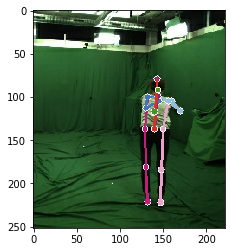

has3d:  True


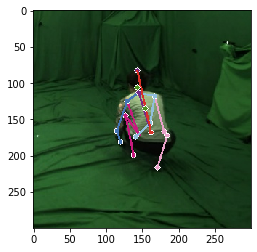

has3d:  True


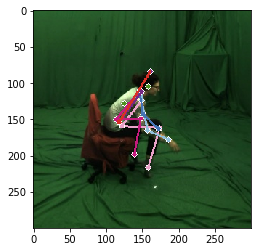

has3d:  True


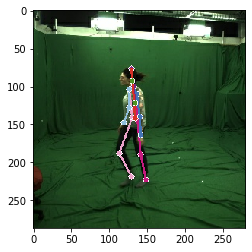

has3d:  True


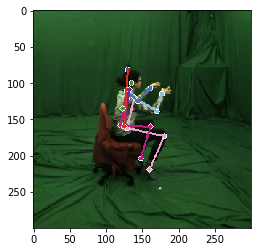

has3d:  True


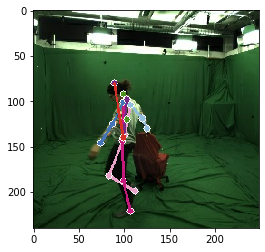

has3d:  True


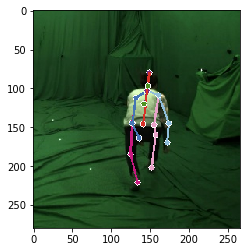

has3d:  True


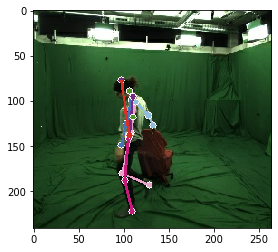

has3d:  True


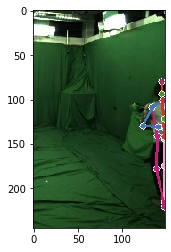

has3d:  True


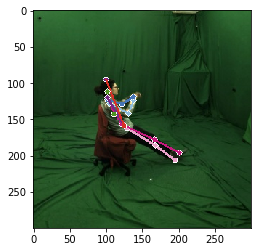

In [5]:
path = join("/data/ssd1/russales/new_records/mpii_3d", "001_train.tfrecord")
read_train_tfrecords(path)

### show test examples

In [6]:
def read_test_tfrecords(path):    
    dataset = tf.data.TFRecordDataset(path).map(parse_test)
    for image, kp2d, kp3d, has3d, sequence in dataset.take(10):
        print('sequence: ', sequence.numpy().decode('utf-8'))
        kp2d = kp2d.numpy()
        show_image(image.numpy(), kp2d[:, :2], kp2d[:, 2])    

sequence:  NA


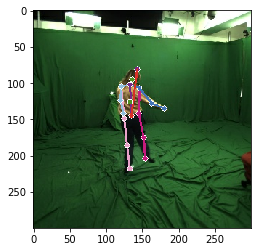

sequence:  NA


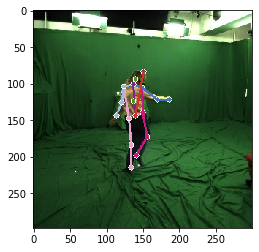

sequence:  NA


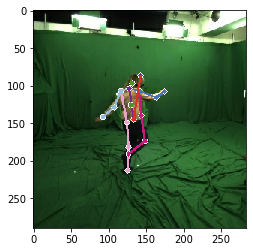

sequence:  NA


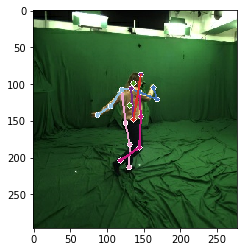

sequence:  NA


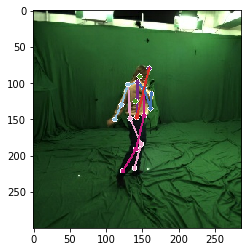

sequence:  NA


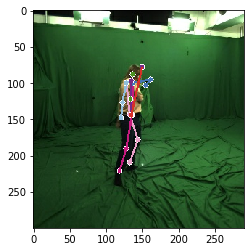

sequence:  NA


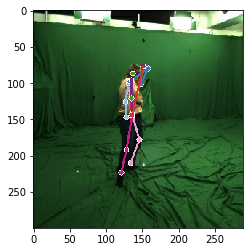

sequence:  NA


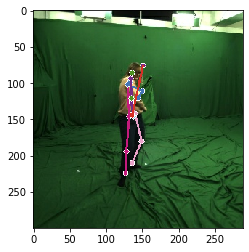

sequence:  NA


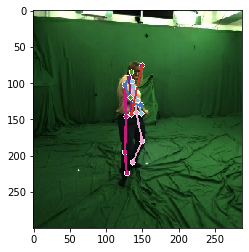

sequence:  NA


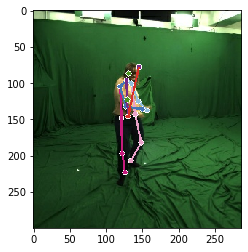

In [7]:
path = join("/data/ssd1/russales/new_records/mpii_3d", "171_train.tfrecord")
read_test_tfrecords(path)

In [8]:
def read_test_tfrecords_3d(path):    
    dataset = tf.data.TFRecordDataset(path).map(parse_test)
    for image, kp2d, kp3d, has3d, sequence in dataset.take(1):
        print('sequence: ', sequence.numpy().decode('utf-8'))
        kp3d = kp3d.numpy()
        kp2d = kp2d.numpy()
        show_image(image.numpy(), kp2d[:, :2], kp2d[:, 2])    
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        show_3d_pose(kp3d, ax)

sequence:  mpii_ts1


<IPython.core.display.Javascript object>


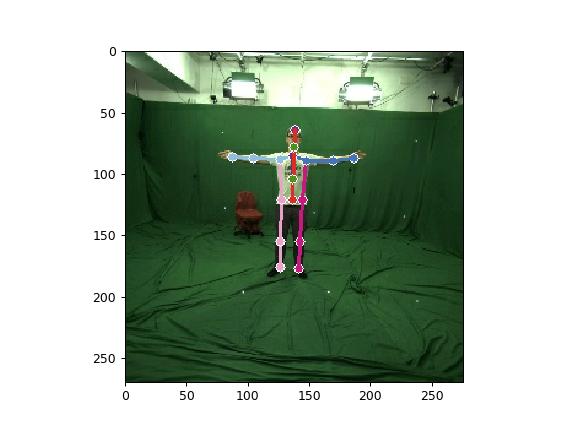

<IPython.core.display.Javascript object>


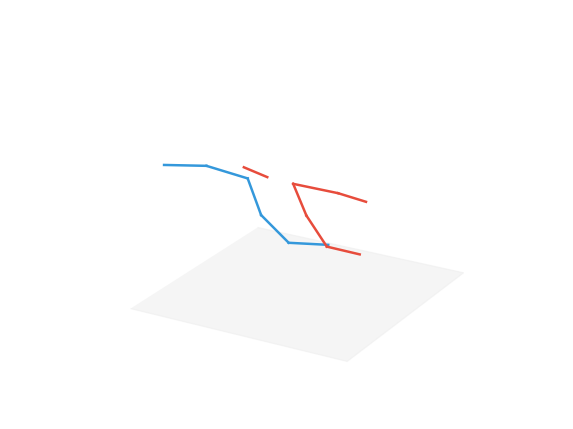

In [26]:
%matplotlib notebook
read_test_tfrecords_3d(path)

## Inspect Dataset Splits (train/val/test)

In [10]:
class CountConfig(Config):
    ROOT_DIR = join('/', 'data', 'ssd1', 'russales')
    DATA_DIR = join(ROOT_DIR, 'new_records')
    DATASETS = ['lsp', 'lsp_ext', 'mpii', 'coco', 'mpii_3d', 'h36m']
    
config = CountConfig()
columns = ['lsp', 'lsp_ext', 'mpii', 'coco', 'mpii_3d', 'h36m']
index = ['# samples', '# 3d samples', '# 2d samples']

In [11]:
def parse_count(example_proto):
    feature_map = {
        'has_3d': tf.io.FixedLenFeature([], dtype=tf.int64)
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    has_3d = features['has_3d']
    return has_3d

In [12]:
def count_train_val_samples(name):
    result = {}
    all_samples, all_3d_samples, all_2d_samples = 0, 0, 0
    for dataset in config.DATASETS:
        tf_records = sorted(glob(join(config.DATA_DIR, dataset, '*_{}.tfrecord'.format(name))))
        if len(tf_records) == 0:
            result[dataset] = [0, 0, 0]
            print("done:", dataset)
            continue
            
        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_count, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(config.BATCH_SIZE, drop_remainder=False) \
            .prefetch(config.BATCH_SIZE * 2)
        
        samples, ds_3d_samples, ds_2d_samples = 0, 0, 0
        for has_3d in ds:
            has_3d = has_3d.numpy()
            count_3d = np.sum(has_3d)
            ds_3d_samples = ds_3d_samples + count_3d
            ds_2d_samples = ds_2d_samples + (has_3d.size - count_3d)
            samples = samples + has_3d.size
        
        all_samples = all_samples + samples
        all_3d_samples = all_3d_samples + ds_3d_samples
        all_2d_samples = all_2d_samples + ds_2d_samples
        
        result[dataset] = [samples, ds_3d_samples, ds_2d_samples]
        print("done:", dataset)
        
    print('\nTotal number of {} samples: {}'.format("train", all_samples))
    print('3d samples: {} - 2d samples: {}'.format(all_3d_samples, all_2d_samples))

    df = pd.DataFrame(result, index=index, columns=columns)
    df = df.astype('int32')
    display(HTML(df.to_html())) 

In [13]:
count_train_val_samples('train')

done: lsp
done: lsp_ext
done: mpii
done: coco
done: mpii_3d
done: h36m

Total number of train samples: 425334
3d samples: 280213 - 2d samples: 145121


,lsp,lsp_ext,mpii,coco,mpii_3d,h36m
# samples,999,9984,17537,116601,166982,113231
# 3d samples,0,0,0,0,166982,113231
# 2d samples,999,9984,17537,116601,0,0


In [14]:
count_train_val_samples('val')

done: lsp
done: lsp_ext
done: mpii
done: coco
done: mpii_3d
done: h36m

Total number of train samples: 11921
3d samples: 6120 - 2d samples: 5801


,lsp,lsp_ext,mpii,coco,mpii_3d,h36m
# samples,999,0,0,4802,0,6120
# 3d samples,0,0,0,0,0,6120
# 2d samples,999,0,0,4802,0,0


In [15]:
def count_test_samples():
    config = CountConfig()

    tf_record_dirs = [join(config.DATA_DIR, dataset, '*_test.tfrecord') for dataset in config.DATASETS]
    tf_records = [tf_record for tf_records in sorted([glob(f) for f in tf_record_dirs]) for tf_record in tf_records]
    
    def parse_test(example_proto):
        feature_map = {
            'sequence': tf.io.FixedLenFeature([], dtype=tf.string)
        }
        features = tf.io.parse_single_example(example_proto, feature_map)
        sequence = features['sequence']
        return sequence

    dataset = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
        .map(parse_test, num_parallel_calls=config.NUM_PARALLEL) \
        .prefetch(config.NUM_PARALLEL * 2)
    
    num_samples, sequence_count = 0, {}
    for sequence in dataset:
        sequence = sequence.numpy().decode("utf-8")
        if sequence not in sequence_count.keys():
            sequence_count[sequence] = 1
        else:
            sequence_count[sequence] += 1
        num_samples += 1

    print('Total number of samples in tf records: ', num_samples)

    return json.dumps(sequence_count, indent=4, sort_keys=True)

In [16]:
data_test = count_test_samples()

df_test = pd.read_json(data_test, orient='index')
display(HTML(df_test.to_html()))

Total number of samples in tf records:  42369


,0
h36m_sub11_Directions 1_cam54138969,59
h36m_sub11_Directions 1_cam55011271,59
h36m_sub11_Directions 1_cam58860488,59
h36m_sub11_Directions 1_cam60457274,59
h36m_sub11_Directions_cam54138969,69
h36m_sub11_Directions_cam55011271,69
h36m_sub11_Directions_cam58860488,69
h36m_sub11_Directions_cam60457274,69
h36m_sub11_Discussion 1_cam54138969,104
h36m_sub11_Discussion 1_cam55011271,104


### inspect visible keypoints 2d

In [17]:
def count_train_kp2d_samples():
    config = CountConfig()
    
    def parse_kp2d(example_proto):
        feature_map = {
            'keypoints_2d': tf.io.VarLenFeature(dtype=tf.float32),
        }
        features = tf.io.parse_single_example(example_proto, feature_map)
        kp2d = tf.reshape(tf.sparse.to_dense(features['keypoints_2d']), (-1, 3))
        return kp2d
    
    result = {}
    for dataset in config.DATASETS:
        tf_records = sorted([glob(join(config.DATA_DIR, dataset, '*_train.tfrecord'))])
        
        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_kp2d, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(config.BATCH_SIZE) \
            .prefetch(config.BATCH_SIZE * 2)
        
        idx = range(19)
        vis_kps = np.ndarray((19,))
        for kp2d in ds:
            kp2d = kp2d.numpy()
            kps = np.transpose(kp2d, (1, 0, 2))
            for i, kp in zip(idx, kps):
                vis_kps[i] = vis_kps[i] + max(np.sum(kp[:, 2]), 0)
            
        print("done:", dataset)
        result[dataset] = vis_kps
        
    return result

In [19]:
columns_kp2d = ['lsp', 'lsp_ext', 'mpii', 'coco', 'mpii_3d', 'h36m']
coco_kp2d = ['ankle_r', 'knee_r', 'hip_r', 'hip_l', 'knee_l', 'ankle_l', 'wrist_r', 'elbow_r', 'shoulder_r', 
            'shoulder_l', 'elbow_l', 'wrist_l', 'neck', 'brain', 'nose', 'eye_l', 'eye_r', 'ear_l', 'ear_r']

data_kp2d = count_train_kp2d_samples()

df_kp2d = pd.DataFrame(data_kp2d, index=coco_kp2d, columns=columns_kp2d)
df_kp2d = df_kp2d.astype('int32')
display(HTML(df_kp2d.to_html()))

# if following error occurs just run again
# Cannot convert non-finite values (NA or inf) to integer

done: lsp
done: lsp_ext
done: mpii
done: coco
done: mpii_3d
done: h36m


,lsp,lsp_ext,mpii,coco,mpii_3d,h36m
ankle_r,982,8902,10342,58756,166982,113231
knee_r,979,9171,12614,72183,166982,113231
hip_r,959,8462,13229,87803,166982,113231
hip_l,924,8274,13396,88146,166982,113231
knee_l,961,9106,12683,72183,166982,113231
ankle_l,957,8948,10320,58880,166982,113231
wrist_r,884,8901,14052,80797,166982,113231
elbow_r,920,8871,14485,86793,166982,113231
shoulder_r,913,8737,14185,105044,166982,113231
shoulder_l,830,8594,14074,105824,166982,113231


In [20]:
df_kp2d.to_csv('dataset_kps.csv')

### inspect smpl/mosh data

In [21]:
def parse_smpl(example_proto):
    feature_map = {
        'pose': tf.io.VarLenFeature(dtype=tf.float32),
        'shape': tf.io.VarLenFeature(dtype=tf.float32),
    }
    features = tf.io.parse_single_example(example_proto, feature_map)
    pose = tf.reshape(tf.sparse.to_dense(features['pose']), (config.NUM_POSE_PARAMS,))
    shape = tf.reshape(tf.sparse.to_dense(features['shape']), (config.NUM_SHAPE_PARAMS,))

    return tf.concat([tf.zeros(3), pose, shape], axis=-1)  # fake cam, pose and shape

In [22]:
def count_train_smpl_samples():
    config = CountConfig()
    
    result = {}
    for dataset in config.SMPL_DATASETS:
        tf_records = sorted([glob(join(config.SMPL_DATA_DIR, dataset, '*_train.tfrecord'))])
        
        ds = tf.data.TFRecordDataset(tf_records, num_parallel_reads=config.NUM_PARALLEL) \
            .map(parse_smpl, num_parallel_calls=config.NUM_PARALLEL) \
            .batch(config.BATCH_SIZE) \
            .prefetch(config.BATCH_SIZE * 2)

        num_smpl = 0
        for smpl in ds:
            num_smpl += smpl.numpy().shape[0]
            
        print("done:", dataset)
        result[dataset] = num_smpl
        
    return result

In [23]:
columns_smpl = ['cmu', 'joint_lim']
index_smpl = ['# samples']

data_smpl = count_train_smpl_samples()

df_smpl = pd.DataFrame(data_smpl, index=index_smpl, columns=columns_smpl)
df_smpl = df_smpl.astype('int32')
display(HTML(df_smpl.to_html()))

done: cmu
done: joint_lim


,cmu,joint_lim
# samples,3934266,181967


### serialize example proto

In [24]:
def print_example(path):
    raw_dataset = tf.data.TFRecordDataset([path])

    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)

In [25]:
path = os.path.join("/data/ssd1/russales/new_records/mpii_3d", "347_test.tfrecord")
print_example(path)

features {
  feature {
    key: "has_3d"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "image_raw"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\016\001\024\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Q